## Goal 
### Predict passenger survival (Survived) from tabular data.

## Imports and settings 

In [16]:
import sys, os
sys.path.append(os.path.abspath("../src"))

import pandas as pd

pd.set_option("display.max_colwidth", 120)

print("Python:", sys.version.split()[0])


Python: 3.13.3


In [17]:
%load_ext autoreload
%autoreload 2

import importlib, features
importlib.reload(features)

from features import add_age_category


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data & observation

In [18]:

df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
print("Shape:", df_train.shape)
df_train.info()
df_train.describe()

Shape: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Problems 
During Exploratory Data Analysis (EDA), I identified several issues that need to be handled before modeling:

1. Missing values in some categories (Age, Cabin, Embarked, Fare (in test data))

2. Noisy / Inconsistent columns

- Cabin: Mix of letters/numbers, too many NaNs → not usable directly.

- Ticket: Inconsistent formats (letters + numbers), duplicated tickets, not clean.

3. Categorical columns

- Sex: Needs encoding (male/female to 0/1).

- Pclass: Should be one-hot encoded for some models.

- Embarked: Categorical with missing values.

4.  Outliers / Skewed data

- Fare: Very skewed distribution with some extremely high values.

- Will need log transformation.

## Missing values in the dataset

In [302]:
def missing_report(ddf: pd.DataFrame) -> pd.DataFrame:
    m = ddf.isna().sum()
    out = pd.DataFrame({"missing": m, "pct": (m / len(ddf) * 100).round(2)})
    return out[out["missing"] > 0].sort_values("missing", ascending=False)

display(missing_report(df_train))
display(missing_report(df_test))

,missing,pct
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


,missing,pct
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24


## Preprocessing Steps 
1. Handle missing values and processing outliers 

2. Standartization and normalization

3. Data conversation 

4. Feature Engineering (FamilySize, HasCabin, Deck, LogFare, Title (from Name).)


### Impute Embarked with most common value (mode)

- Only a couple of rows have missing Embarked values

- I use the most common category (mode) from train data as the fill value for missing data

- Why use train’s most common value for test?
Because the model should only “learn” from the train data. If we calculate the mode from test, we’d be peeking into data the model shouldn’t see (data leakage). That’s why we take the most common Embarked value from train and use it for both train and test.

## Handling the Age Column

- The Age column has many missing values (~177).
- To preserve age-related patterns, I will use passengers’ Title (from the Name column) as a grouping variable.
- Extract title (Mr, Mrs, Miss etc) which show us age, gender and social status (Title feature)
- Map unusual titles to "Other"
- Missing ages will be filled with the median age of passengers sharing the same Title (e.g., Mr, Mrs, Miss, Master).

## Handling the Ticket Column

- The Ticket column has many inconsistencies (mix of numbers and letters) and does not provide clear, structured information.

- Some tickets are shared by multiple passengers, which could indicate family or group travel — but this information is already captured by feature FamilySize.

- Because of its noisy nature and limited predictive power, I will drop the raw Ticket column.

## Data conversation

### Convert data in Sex column 
- I convert categorical values male/female to numerical format for the better performance from the model (for both train and test data)


### Handling the Pclass Column
- The Pclass column represents passenger class (1st, 2nd, 3rd). It is categorical, for linear models it’s safer to one-hot encode Pclass. 
- I create three separate binary columns
- I keep Pclass_raw data for EDA

## Engineering features

### Handling the Cabin Column (HasCabin, Deck features)

- The Cabin column has many missing values (~77%), so keeping the raw data is not useful for the model.

- To still capture useful information, I will create a new binary feature HasCabin (1 if Cabin is present, 0 otherwise).

- Additionally, I will extract the deck letter (first character of the cabin, e.g., A, B, C…) into a new column, and assign Unknown for missing values.

- I keep the raw Cabin column for reference, but it will not be used as a model feature.

### Title feature  (look above at the Age column adjestments)
- Extract title (Mr, Mrs, Miss etc) which show us age, gender and social status 
- Map unusual titles to "Other"

### Age_category feature 

- Creare age categories: child 0-17, adult 18-59, senior 60-100

### Create FamilySize feature  

- FamilySize = SibSp + Parch + 1 (the +1 includes the passenger themselves).

- This feature may help the model, because survival chances could depend on whether someone traveled alone or with family.

### Handling the Fare Column (LogFare feature)

- The Fare column represents the ticket price paid by a passenger.

- It has a wide range (from 0 up to 512).

- A few tickets are duplicated because passengers often shared a ticket (families or groups).

- I apply a log transformation (LogFare = log1p(Fare)) to reduce the effect of extreme values and make the distribution more balanced. Taking the log “compresses” the big numbers and spreads out the small ones that makes the distribution more balanced.

- I keep both raw Fare and engineered LogFare


## Visualisation

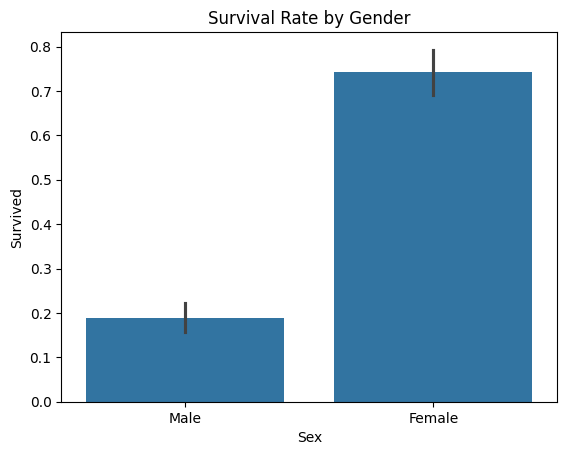

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x="Sex", y="Survived", data=df_train)
plt.title("Survival Rate by Gender")
plt.xticks([0, 1], ["Male", "Female"])
plt.show()

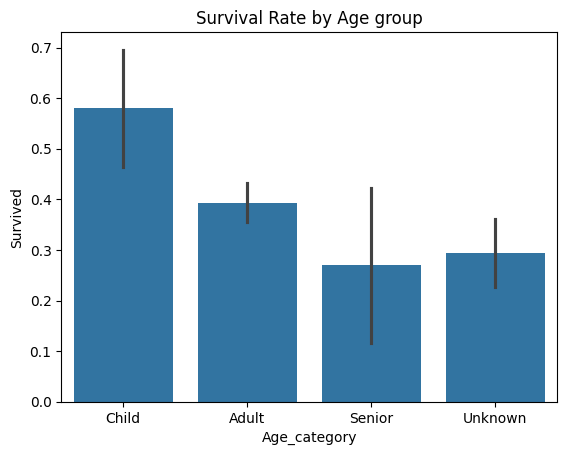

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from features import add_age_category



df_train = add_age_category(df_train)

sns.barplot(x="Age_category", y="Survived", data=df_train)
plt.title("Survival Rate by Age group")
plt.show()


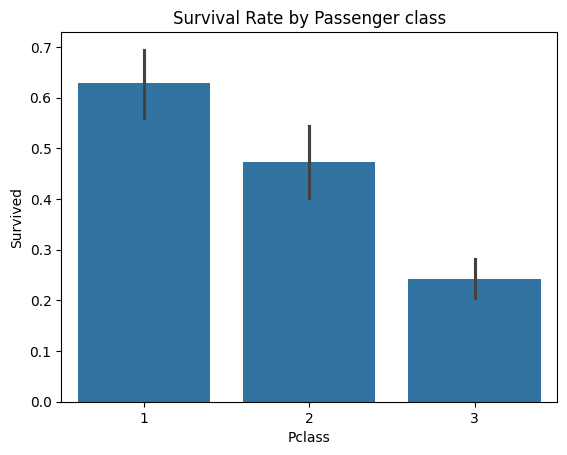

In [8]:

sns.barplot(x="Pclass", y="Survived", data=df_train)
plt.title("Survival Rate by Passenger class")
plt.show()

## Models and Accuracy

In [ ]:

import pandas as pd
from features import add_rowwise_features, fit_train_stats, apply_stats, add_age_category
from pipeline import get_model_zoo, evaluate_models


df_train = pd.read_csv("../data/train.csv")


df_feat = add_rowwise_features(df_train)
stats = fit_train_stats(df_feat)
df_feat = apply_stats(df_feat, stats)
df_feat = add_age_category(df_feat)


pclass_dummies = pd.get_dummies(df_feat["Pclass"], prefix="Pclass", dtype=int)
df_feat = pd.concat([df_feat, pclass_dummies], axis=1)


features = ["Sex", "Age", "LogFare", "FamilySize", "HasCabin", "Pclass_1", "Pclass_2", "Pclass_3"]
X = df_feat[features].copy()
X["Sex"] = X["Sex"].map({"male": 0, "female": 1}).astype(int)
y = df_feat["Survived"].astype(int)

models = get_model_zoo(random_state=42)
leaderboard, results = evaluate_models(models, X, y)
leaderboard


,model,accuracy_mean,accuracy_std,roc_auc_mean,roc_auc_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
3,RandomForest,0.829402,0.013141,0.881548,0.015283,0.808666,0.019034,0.728005,0.035932,0.765699,0.022503
4,GradBoost,0.838365,0.024311,0.872239,0.011237,0.828897,0.044475,0.730861,0.038682,0.776154,0.035108
0,LogReg,0.803578,0.020529,0.860468,0.020890,0.758451,0.030321,0.716240,0.035259,0.736507,0.030567
1,KNN(k=5),0.806930,0.020824,0.859967,0.014701,0.770354,0.039313,0.710571,0.035989,0.738475,0.028373
2,DecisionTree,0.805825,0.027271,0.851562,0.020682,0.754958,0.036710,0.730776,0.039053,0.742646,0.037698




The Titanic survival prediction project compared five different machine learning models: Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, and Gradient Boosting.

Gradient Boosting achieved the highest overall accuracy (83.8%) and the strongest F1 score, indicating a good balance between precision and recall.

Random Forest achieved the highest ROC AUC (0.88), meaning it was the best at ranking survivors versus non-survivors, and delivered stable performance across folds.

Logistic Regression, KNN, and Decision Tree all performed reasonably well (around 80% accuracy), providing solid baselines but falling slightly behind the ensemble methods.

Overall, ensemble models (Random Forest and Gradient Boosting) outperformed the simpler algorithms, showing that survival on the Titanic involved complex, non-linear relationships between features such as age, sex, class, and family size.

In [29]:
from pipeline import get_model_zoo, evaluate_models, holdout_evaluate
import joblib

# Build feature matrix
features = ["Sex", "Age", "LogFare", "FamilySize", "HasCabin", "Pclass_1", "Pclass_2", "Pclass_3"]
X = df_feat[features]
X["Sex"] = X["Sex"].map({"male": 0, "female": 1}).astype(int)
y = df_feat["Survived"].astype(int)

# Get all models
models = get_model_zoo(random_state=42)
leaderboard, _ = evaluate_models(models, X, y)

print(leaderboard)

# Choose the best one, e.g. Gradient Boosting
best_model = models["GradBoost"]
best_model.fit(X, y)

# Save it
joblib.dump(best_model, "titanic_model.pkl")


C:\Users\46739\AppData\Local\Temp\ipykernel_35836\2645791252.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Sex"] = X["Sex"].map({"male": 0, "female": 1}).astype(int)


          model  accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std  \
3  RandomForest       0.829402      0.013141      0.881548     0.015283   
4     GradBoost       0.838365      0.024311      0.872239     0.011237   
0        LogReg       0.803578      0.020529      0.860468     0.020890   
1      KNN(k=5)       0.806930      0.020824      0.859967     0.014701   
2  DecisionTree       0.805825      0.027271      0.851562     0.020682   

   precision_mean  precision_std  recall_mean  recall_std   f1_mean    f1_std  
3        0.808666       0.019034     0.728005    0.035932  0.765699  0.022503  
4        0.828897       0.044475     0.730861    0.038682  0.776154  0.035108  
0        0.758451       0.030321     0.716240    0.035259  0.736507  0.030567  
1        0.770354       0.039313     0.710571    0.035989  0.738475  0.028373  
2        0.754958       0.036710     0.730776    0.039053  0.742646  0.037698  


['titanic_model.pkl']

In [30]:
import joblib

# Example: save the fitted model and stats
joblib.dump(best_model, "titanic_model.pkl")
joblib.dump(stats, "titanic_stats.pkl")  # if you need imputation info


['titanic_stats.pkl']

## Conclusion

In this project, I explored the Titanic dataset to predict passenger survival.

EDA revealed that survival was imbalanced (~62% died, ~38% survived) and was strongly influenced by gender (females had higher survival rates) and class (1st class passengers survived more often).

Missing values were addressed by imputing Age with title-based medians and Embarked with the most common port, while new features such as FamilySize, HasCabin, Title, and LogFare were engineered.

The most important predictors included Sex, Pclass, and Age, with engineered features further improving signal.

In model evaluation, Logistic Regression, KNN, and Decision Tree achieved ~80% accuracy, while ensemble models (Random Forest and Gradient Boosting) performed best, reaching ~84% accuracy and an ROC AUC above 0.87.